# 3MODELS: 2 CATBOOST + 1 LIGHTGBM  + 1 XGBOOST

# LIGHTGBM MODEL

In [5]:
#import necessary dependecies
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import KFold, cross_val_score, GroupKFold, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from tqdm import tqdm
import math
import gc
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

In [6]:
data_path ='/Users/DELL/Desktop/Hackhathons/Reservation/data_all/'
input_path ='/Users/DELL/Desktop/Hackhathons/Reservation/data_all/'
save_path = '/Users/DELL/Desktop/Hackhathons/Reservation/data_all/'
trains='train.csv'
tests='test.csv'
submissions='submit.csv'

In [3]:
#define some fxn to read the data set
def read_train():
    train =pd.read_csv(data_path + trains, parse_dates=['arrival_date'])
    return train

def read_test():
    test =pd.read_csv(data_path + tests, parse_dates=['arrival_date'])
    return test

def read_submission():
    submission =pd.read_csv(data_path + submissions)
    return submission

#Assign defined fxns to variables
train = read_train();test=read_test();submission=read_submission()

In [4]:
test_id = test['id']

In [5]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)

# FEATURE ENGINEERING

In [6]:
data['not_crawling_being'] = data.children+data.adults
data["Beings"] = data["adults"]+ data["children"]+ data["babies"]
data["adr_pp"] = data["adr"] / (data["adults"] +data["children"])
data['dayofweek'] = pd.DatetimeIndex(data['arrival_date']).dayofweek
data['is_weekend'] = data.dayofweek.isin([5,6])*1
data['quarter'] = data['arrival_date'].dt.quarter
data['month_of_arrival'] = data['arrival_date'].dt.month
data['year_of_arrival'] = data['arrival_date'].dt.year
data['day_of_arrival'] = data['arrival_date'].dt.day
data['is_year_start'] = data['arrival_date'].dt.is_year_start
data['is_year_end'] = data['arrival_date'].dt.is_year_end
data['is_month_start'] = data['arrival_date'].dt.is_month_start
data['is_month_end'] = data['arrival_date'].dt.is_month_end
data['is_quarter_start'] = data['arrival_date'].dt.is_quarter_start
data["night/day"] = data["stays_in_weekend_nights"] + data["stays_in_week_nights"]
data['billing']=data['night/day']*data.adr
data['assigned_and_reserrved'] = data['assigned_room_type'] + '_' + data['reserved_room_type']
data['room_assignment'] = data['reserved_room_type']==data['assigned_room_type']

In [7]:
reservation_data=data[data.is_canceled.notnull()].reset_index(drop=True)
test=data[data.is_canceled.isna()].reset_index(drop=True)

# EXPLORATORY DATA ANALYSIS

## UNIVARIATE ANALYSIS

## BIVARIATE ANALYSIS

In [8]:
cust_id = reservation_data.groupby('is_canceled').count()['id'].reset_index().sort_values(by='id',ascending=True)
cust_id.style.background_gradient(cmap='Greens')

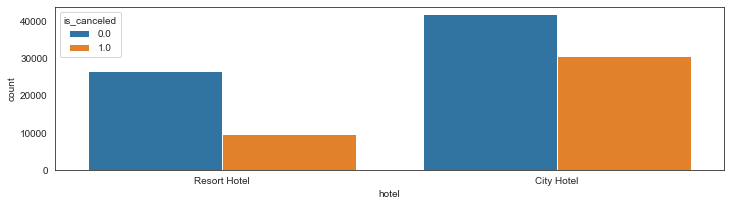

In [9]:
plt.figure(figsize=(12,3))
sns.set_style("white")
sns.countplot(x='hotel', hue='is_canceled', data=reservation_data)
plt.show()

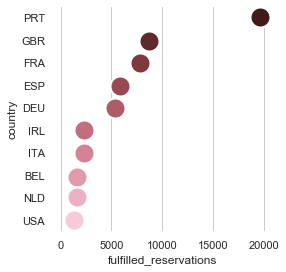

In [10]:
reservation_country = pd.DataFrame(reservation_data.groupby('country').sum())
reservation_country = reservation_country.loc[:,['is_canceled','stay_nights','not_crawling_being']]
reservation_country['reservation_count'] = reservation_data.groupby('country').hotel.count()
reservation_country['cancellation_rate'] =  reservation_country.is_canceled.div(reservation_country.reservation_count)
reservation_country['fulfillment_rate'] =  1-reservation_country.is_canceled.div(reservation_country.reservation_count)
reservation_country['fulfilled_reservations'] =  reservation_country['reservation_count']-reservation_country['is_canceled']
sns.set(style="whitegrid")
toprint = reservation_country.reset_index().sort_values(by='fulfilled_reservations', ascending=False).head(10)
g = sns.PairGrid(toprint, x_vars=toprint.columns[7:8], y_vars=['country'], height=4)
sns.despine(left=True, bottom=True)
g.map(sns.stripplot, size=20, orient="h", palette="ch:s=1,r=-.1,h=1_r", linewidth=2, edgecolor="w")
plt.show()

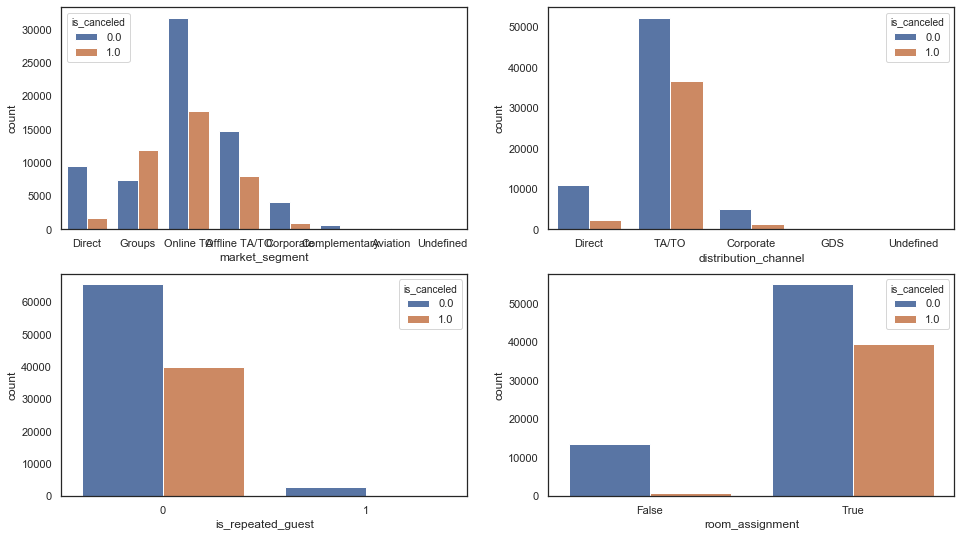

In [11]:
sns.set_style("white")
fig, axes = plt.subplots(2, 2, figsize=(16,9))
sns.countplot(data=reservation_data, x='market_segment', hue='is_canceled', ax=axes[0][0])
sns.countplot(data=reservation_data, x='distribution_channel', hue='is_canceled', ax=axes[0][1])
sns.countplot(data=reservation_data, x='is_repeated_guest', hue='is_canceled', ax=axes[1][0])
sns.countplot(data=reservation_data, x='room_assignment', hue='is_canceled', ax=axes[1][1])
plt.show()

Q. In which period of the year the number of bookings peak? Can you spot any seasonality?
Now let's address the seasonality of the bookings, by finding the months during which the bookings peak.

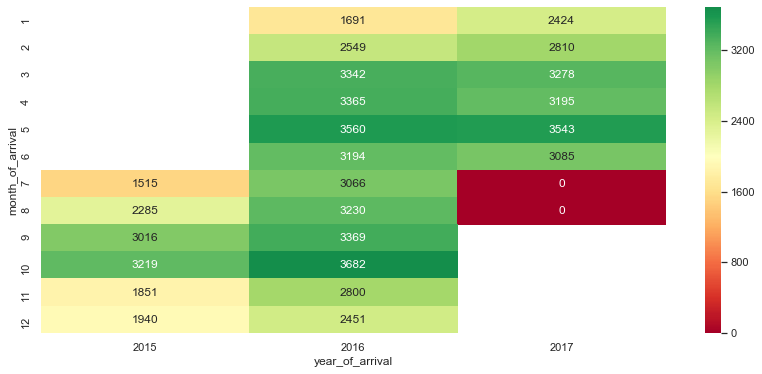

In [12]:
bookings = reservation_data[reservation_data['is_canceled']==0].pivot_table(index='month_of_arrival', columns='year_of_arrival', values='hotel', aggfunc=len, fill_value=0)
bookings.index = pd.CategoricalIndex(bookings.index, categories=[1, 2, 3, 4,5,6,7,8,9,10,11,12], ordered=True)
bookings = bookings.sort_index()
mask = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]])
f, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(bookings, center=2000, annot=True, mask=mask, fmt="d", ax=ax, cmap=plt.cm.RdYlGn)
sns.set_context('paper')
plt.show()

In [13]:
sns.countplot(data=reservation_data, x='room_assignment', hue='is_canceled', ax=axes[1][1])
plt.show()

## MULTIVARIATE ANALYSIS

Cancellation Financial impact


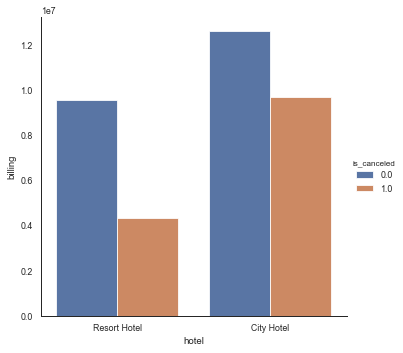

In [14]:
print('Cancellation Financial impact')
sns.catplot(x='hotel', y='billing', hue='is_canceled', estimator=sum, ci=None, kind='bar', data=reservation_data)
plt.show()

The majority of canceled bookings are in 'City Hotels' even though both establishments suffer from cancellation to a certain degree.

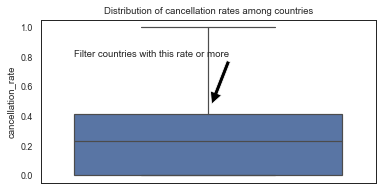

In [15]:
plt.figure(figsize=(6,3))
sns.set_style("white")
sns.boxplot(data=reservation_country, y='cancellation_rate')
plt.annotate('Filter countries with this rate or more', xy=(0.01, 0.48), xytext=(-0.4, 0.8),
            arrowprops=dict(facecolor='black', shrink=1),
            )
plt.title('Distribution of cancellation rates among countries')
plt.show()

The countries on the top of the chart are all european, with a remarkable lead for Portugal. If we hypothesize that the dataset is for bookings in the same geographical area, we may claim that the establishments object of the bookings are located in the Iberian peninsula in order to justify the affluence of customers from this region. And given that Portugal has a small population (10M) compared to the UK, France and Spain, it would be hard to claim that the hotels are Spain. Thus, we conclude that the stablishments are in Portugal.

Now let's move back to our dataset and analyze the countries with the highest cancellation rates. It is common sense that a high number of cancellations for a given country could be due to the fact that the overall reservations are also important. So the suitable approach would be to compare percentages.

After we've distributed the countries per rate of cancellation, we will filter the countries higher than the 75th percentile.
The calculations determined that the 75th quantile is at a cancellation rate of 45%. Nonetheless, we will neglect the countries with low reservations count (<100) even if they present high cancellation rates for the sake of the analysis.
The over-sized points are countries with high cancellation rates while at the same time having an important number of reservations overall. Let's zoom in on the cluster at the left to enumerate those countries.

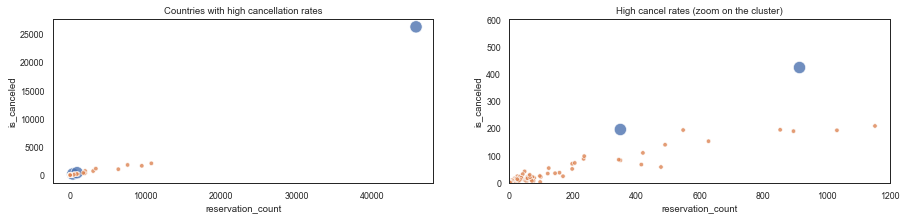

In [16]:
#print(reservation_country.quantile(0.75))
reservation_country_plot = reservation_country
reservation_country_plot['hue'] = (reservation_country['cancellation_rate']<0.45)|(reservation_country['reservation_count']<100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
sns.set_style('whitegrid')
ax1.set_title('Countries with high cancellation rates')
sns.scatterplot(data=reservation_country_plot, x='reservation_count', y='is_canceled', size='hue', hue='hue', sizes=(20,150), alpha=0.8, legend=False, ax=ax1)
ax2.set_title('High cancel rates (zoom on the cluster)')
sns.scatterplot(data=reservation_country_plot, x='reservation_count', y='is_canceled', hue='hue', size='hue', sizes=(20,150), alpha=0.8, legend=False, ax=ax2)
plt.xlim(0,1200)
plt.ylim(0,600)
plt.show()

In fact, we deduced that these are the columns with the highest correlation with the label to predict:

Also, the cancellation rate varies a lot for different values of 'market_segment' and 'distribution_channel'
Repeated guests cancel their bookings a lot fewer than non-repeated guests do.
As for the last attribute, there is a perfect connection between the values. For each row that has 'reservation_status' set to 'Check-Out', the label 'is_canceled' is null, and is equal to '1' on the other cases. So this feature will be left out during the training.
NB: A test has been done with the feature 'reservation_status', after creating the dummies, and it generated a model with a perfect score with DecisionTree as the algorithm.

Before moving on to the ML part, one peculiar thing that got our attention while cleaning the data, is the presence of 715 rows with null numbers of stay nights (weekends or throughout the week) and a null average daily rate. We investigated the rows to find patterns, and observed that they are scattered along all the features (hotel, arrival dates, meals...), except that:

The majority are locals (PRT) and the bookings are 'checked-out'
They are related to 'transient' clients and signed for B&B
They had 'No-deposits'
Booked for 2 people mostly (sometimes 1 person) and almost all of them had 0 'days in waiting list'
We immediately started hypothesizing:
H1: They could be related to clients showing up at he last minute (0 days waiting list) and leaving immediately (maybe not liking the establishment, price...), but they're all labeled as 'Checked-out'
H2: Neither is it plausible to say that it could be clients who book lunch/dinner or to the bar, as it does not make sense to create a booking for that, and a lot of bookings are B&B.
...among another 3 or 4 hypotheses that were far-fetched. We finally decided it has something to do with the validity of the data. So, whether it is maliciously rigged or just a mistake in record keeping, this means that there are bills not accounted for in the establishement. Let's calculate the supposed losses, and drop the rows.

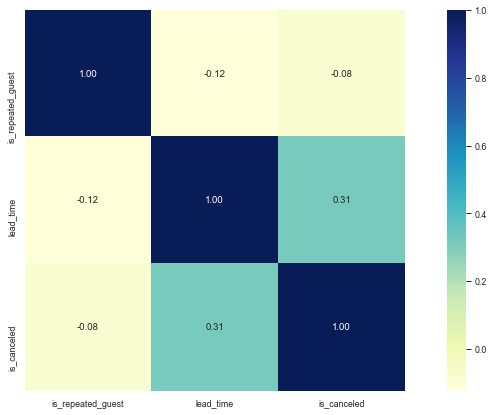

In [17]:
#correlelogram- plot heatmap to find correlation among features
corrmat =reservation_data.corr()
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(reservation_data[['is_repeated_guest', 'lead_time','is_canceled']].corr(), square=True, cmap="YlGnBu", annot=True, fmt=".2f")

In [18]:
#Average bill amount = average adr for checked-out bookings * average stay duration
bb= reservation_data[reservation_data['is_canceled']==0].adr.mean()*reservation_data[reservation_data['is_canceled']==0].stays_in_week_nights.mean()
#Subset of fulfilled bookings = 680
rr = reservation_data[(reservation_data['stays_in_week_nights']==0) & (reservation_data['is_canceled']==0)].is_canceled.value_counts()
print('The average amount to be expected from the bookings week_nights is $%.2f' %(bb*rr))
reservation_data = reservation_data[reservation_data['stays_in_week_nights']!=0]

The average amount to be expected from the bookings week_nights is $1208936.82


In [19]:
## Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [20]:
reservation_data = reduce_mem_usage(reservation_data)
test = reduce_mem_usage(test)

Mem. usage decreased to 13.40 Mb (57.1% reduction)
Mem. usage decreased to  1.30 Mb (57.0% reduction)


In [21]:
#columns with object data types
object_dtypes = reservation_data.loc[:, reservation_data.dtypes == np.object];object_dtypes.columns

Index(['hotel', 'meal', 'country', 'market_segment', 'distribution_channel',
       'reserved_room_type', 'assigned_room_type', 'customer_type',
       'assigned_and_reserrved'],
      dtype='object')

In [22]:
# After cleaning, separate Resort and City hotel
# To know the acutal visitor numbers, only bookings that were not canceled are included. 
rh = reservation_data.loc[(reservation_data["hotel"] == "Resort Hotel") & (reservation_data["is_canceled"] == 0)]
ch = reservation_data.loc[(reservation_data["hotel"] == "City Hotel") & (reservation_data["is_canceled"] == 0)]

In [23]:
# get number of acutal guests by country
reservation_country = pd.DataFrame(reservation_data.loc[reservation_data["is_canceled"] == 0]["country"].value_counts())
reservation_country.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = reservation_country["Number of Guests"].sum()
reservation_country["Guests in %"] = round(reservation_country["Number of Guests"] / total_guests * 100, 2)
reservation_country["country"] = reservation_country.index

# pie plot
fig = px.pie(reservation_country,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [24]:
# total bookings per market segment (incl. canceled)
segments=reservation_data["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

In [25]:
# show on map
guest_map = px.choropleth(reservation_country,
                    locations=reservation_country.index,
                    color=reservation_country["Guests in %"], 
                    hover_name=reservation_country.index, 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

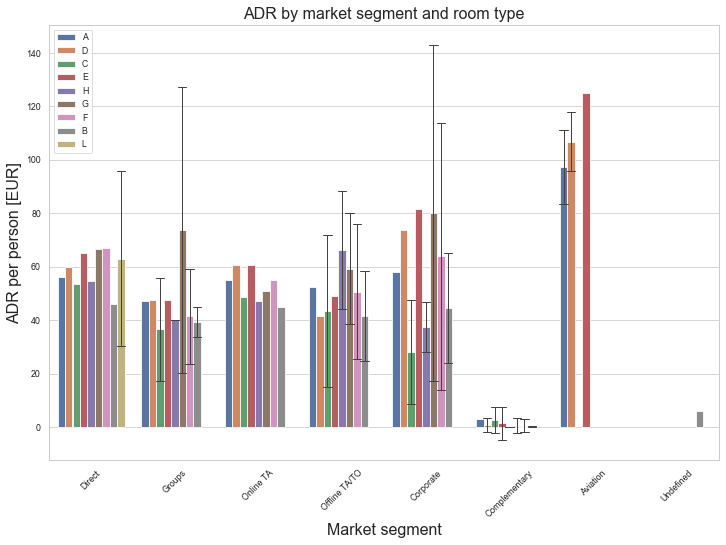

In [26]:
# price per night (ADR) and person based on booking and room.
# show figure:
plt.figure(figsize=(12, 8))
sns.barplot(x="market_segment",
            y="adr_pp",
            hue="reserved_room_type",
            data=reservation_data,
            ci="sd",
            errwidth=1,
            capsize=0.1)
plt.title("ADR by market segment and room type", fontsize=16)
plt.xlabel("Market segment", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("ADR per person [EUR]", fontsize=16)
plt.legend(loc="upper left")
plt.show()

In [27]:
reservation_data['hotel'].unique() #city -1

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [28]:
reservation_data['country'].unique()

array(['PRT', 'GBR', 'NLD', 'ESP', 'FRA', 'IRL', 'DEU', 'CN', 'ISR',
       'ITA', 'RUS', 'LUX', 'NOR', 'HRV', 'USA', 'BRA', 'CHE', 'TUR',
       'AUT', 'BEL', 'SWE', 'CHN', 'MAR', 'DNK', 'POL', 'Unknown', 'AGO',
       'NGA', 'AUS', 'IDN', 'GRC', 'MEX', 'ARG', 'MOZ', 'ROU', 'TJK',
       'COL', 'JPN', 'DOM', 'UKR', 'CZE', 'EGY', 'FIN', 'GEO', 'SAU',
       'IND', 'HUN', 'CHL', 'SRB', 'SVK', 'DZA', 'NZL', 'IRN', 'KOR',
       'TZA', 'MYS', 'TUN', 'ABW', 'ZWE', 'MKD', 'PER', 'CPV', 'AZE',
       'LVA', 'LBN', 'TMP', 'TWN', 'CUB', 'LTU', 'SVN', 'EST', 'JAM',
       'ZAF', 'JOR', 'BGR', 'THA', 'ALB', 'AND', 'GGY', 'GIB', 'CAF',
       'URY', 'CYP', 'ASM', 'QAT', 'CMR', 'RWA', 'ECU', 'MNE', 'KWT',
       'SGP', 'JEY', 'HKG', 'IMN', 'PRI', 'VGB', 'CRI', 'VEN', 'VNM',
       'IRQ', 'BIH', 'MUS', 'PAK', 'ARE', 'ISL', 'CIV', 'SUR', 'MAC',
       'BLR', 'KNA', 'PHL', 'BHR', 'SEN', 'LBY', 'BRB', 'DMA', 'MLT',
       'OMN', 'LCA', 'PYF', 'GNB', 'MDV', 'BOL', 'TGO', 'GTM', 'ATA',
       'MLI', 'BG

# OUTLIERS DETECTION

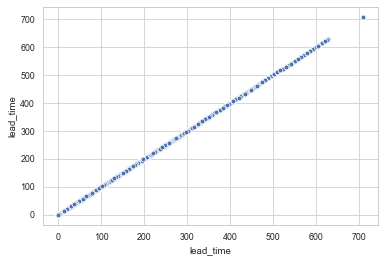

In [29]:
sns.scatterplot (x='lead_time', y='lead_time', data=reservation_data)

In [30]:
lead = reservation_data[reservation_data['lead_time'] > 670].index
ms = reservation_data[reservation_data['market_segment'] == 'Undefined'].index
ar = reservation_data[reservation_data['assigned_room_type'] == 'L'].index 
sn = reservation_data[reservation_data['stays_in_week_nights'] > 48].index
bb = reservation_data[reservation_data['babies'] > 8].index

In [31]:
reservation_data.drop(lead, axis=0, inplace=True)
reservation_data.drop(ms, axis=0, inplace=True)
reservation_data.drop(ar, axis=0, inplace=True)
reservation_data.drop(sn, axis=0, inplace=True)
reservation_data.drop(bb, axis=0, inplace=True)

In [32]:
reservation_data.columns

Index(['id', 'hotel', 'is_canceled', 'lead_time', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'arrival_date', 'not_crawling_being', 'Beings', 'adr_pp', 'dayofweek',
       'is_weekend', 'quarter', 'month_of_arrival', 'year_of_arrival',
       'day_of_arrival', 'is_year_start', 'is_year_end', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'night/day', 'billing',
       'assigned_and_reserrved', 'room_assignment'],
      dtype='object')

# Target Encoding + One Hot Encoding

In [33]:
import category_encoders as ce
oce = ce.OneHotEncoder(cols=['hotel'])
hce = ce.TargetEncoder(cols=['meal', 'country', 'market_segment', 'distribution_channel',
'reserved_room_type', 'assigned_room_type', 'customer_type','assigned_and_reserrved'],smoothing=40,min_samples_leaf=7)

In [34]:
reservation_data= reservation_data.reset_index()
test= test.reset_index()

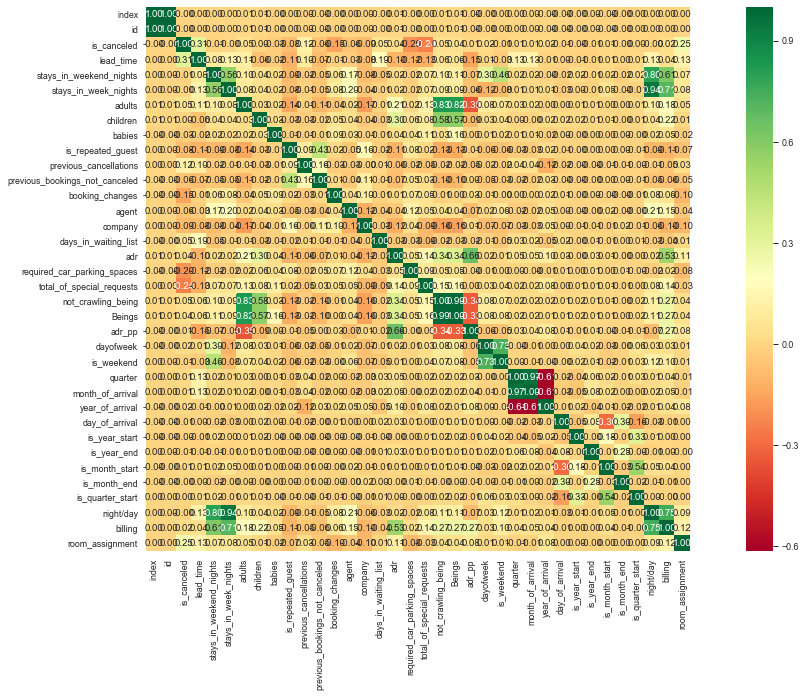

In [35]:
#correlelogram- plot heatmap to find correlation among features
corrmat =reservation_data.corr()
f, ax = plt.subplots(figsize=(20,10))
sns.heatmap(reservation_data.corr(), square=True, cmap=plt.cm.RdYlGn, annot=True, fmt=".2f")

In [36]:
cols_drop=['id', 'arrival_date','not_crawling_being','billing','index']
reservation_data=reservation_data.drop(cols_drop, axis=1);test=test.drop(cols_drop, axis=1)

In [37]:
X=reservation_data.drop(['is_canceled'], axis=1);test=test.drop(['is_canceled'], axis=1)
y=reservation_data.is_canceled

In [38]:
X = oce.fit_transform(X)
X = hce.fit_transform(X,y)
test = oce.transform(test)
test = hce.transform(test)

In [39]:
test=test.drop(['hotel_2'], axis=1)
X=X.drop(['hotel_2'], axis=1)

In [40]:
print(X.shape,test.shape)

(101808, 40) (10099, 40)


In [41]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RepeatedStratifiedKFold

In [42]:
param = { 
         'objective':'binary',
         'max_depth': 12,
         'learning_rate': 0.4,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "metric": 'auc',
        'seed':1993,
    'num_boost_round':500,
         "verbose": 0}

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

In [44]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GroupKFold, train_test_split
    
errcb=[]
y_pred_totcb=[]
fold=RepeatedStratifiedKFold(n_splits=4, random_state=12345, n_repeats=6)
i=1

for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=LGBMClassifier(**param, random_state=188)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val)],verbose=50, early_stopping_rounds=300)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

err:  0.9958465989497698
err:  0.9966043571528261
err:  0.9961598267100193
err:  0.9965237812535208
err:  0.9962319899680434
err:  0.9965316869619982
err:  0.996516262629525
err:  0.9958409609478537
err:  0.9961076848882894
err:  0.9962493449169219
err:  0.9961646718267915
err:  0.9966060990329928
err:  0.9961159255290669
err:  0.9965791179324843
err:  0.9964138066158866
err:  0.9960263481714559
err:  0.9964082484825083
err:  0.9963737007271553
err:  0.9961067272481435
err:  0.99624012705766
err:  0.9966488115513208
err:  0.9967129999574142
err:  0.9953779488612456
err:  0.9963882459186025


In [45]:
np.mean(errcb)

0.9962823030538123

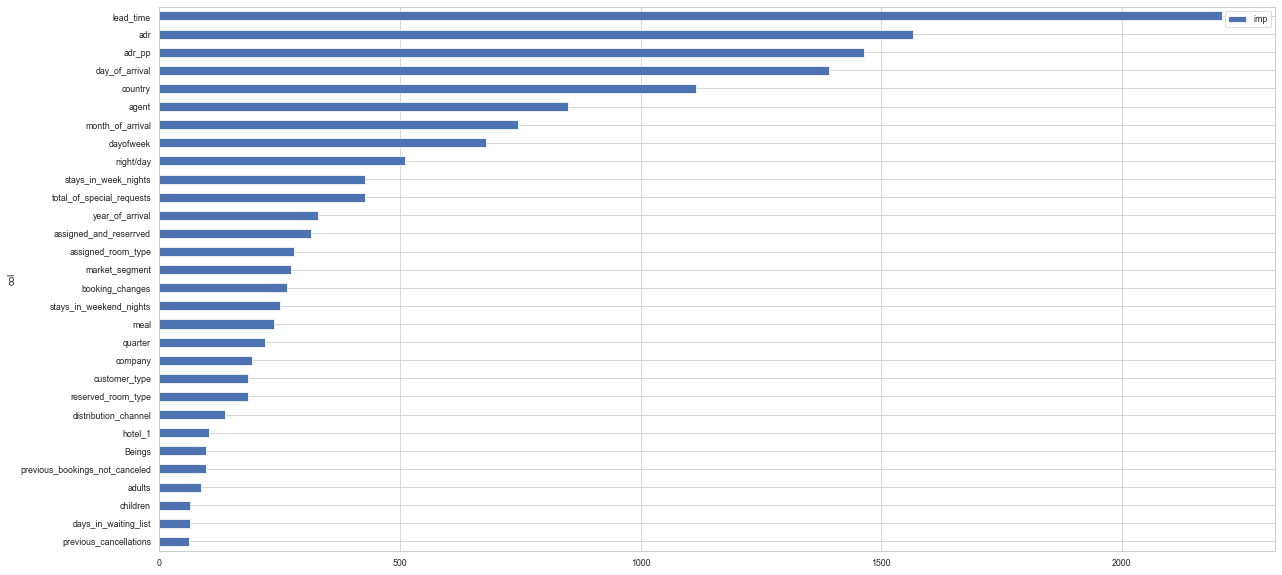

In [46]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('LGBM_feature_importance.png')    

In [47]:
d = {"id": test_id, 'is_canceled': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["id", 'is_canceled']]

In [48]:
test_predictions.head()

id  is_canceled
0  108786     0.223128
1  108787     0.298389
2  108788     0.000003
3  108789     0.812428
4  108790     0.468958

In [49]:
test_predictions.to_csv('lgbm.csv', index=False)

# CATBOOST MODEL 1

In [390]:
#define some fxn to read the data set
def read_train():
    train =pd.read_csv('train.csv',parse_dates=['arrival_date'])
    return train

def read_test():
    test =pd.read_csv('test.csv',parse_dates=['arrival_date'])
    return test

def read_submission():
    submission =pd.read_csv('submit.csv')
    return submission

#Assign defined fxns to variables
train = read_train();test=read_test();submission=read_submission()

In [391]:
test_id = test['id']

In [392]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)

In [393]:
data['not_crawling_being'] = data.children+data.adults
data["Beings"] = data["adults"]+ data["children"]+ data["babies"]
data["adr_pp"] = data["adr"] / (data["adults"] +data["children"])
data['dayofweek'] = pd.DatetimeIndex(data['arrival_date']).dayofweek
data['is_weekend'] = data.dayofweek.isin([5,6])*1
data['quarter'] = data['arrival_date'].dt.quarter
data['month_of_arrival'] = data['arrival_date'].dt.month
data['year_of_arrival'] = data['arrival_date'].dt.year
data['day_of_arrival'] = data['arrival_date'].dt.day
data['is_year_start'] = data['arrival_date'].dt.is_year_start
data['is_year_end'] = data['arrival_date'].dt.is_year_end
data['is_month_start'] = data['arrival_date'].dt.is_month_start
data['is_month_end'] = data['arrival_date'].dt.is_month_end
data['is_quarter_start'] = data['arrival_date'].dt.is_quarter_start
data['assigned_and_reserrved'] = data['assigned_room_type'] + '_' + data['reserved_room_type']
data["night/day"] = data["stays_in_weekend_nights"] + data["stays_in_week_nights"]
data['billing']=data['night/day']*data.adr
data['room_assignment'] = data['reserved_room_type']==data['assigned_room_type']

In [394]:
data[['room_assignment','assigned_and_reserrved']]

room_assignment assigned_and_reserrved
0                  True                    A_A
1                 False                    D_A
2                  True                    A_A
3                  True                    A_A
4                  True                    D_D
...                 ...                    ...
118879             True                    D_D
118880             True                    D_D
118881             True                    A_A
118882             True                    E_E
118883             True                    G_G

[118884 rows x 2 columns]

In [395]:
reservation_data=data[data.is_canceled.notnull()].reset_index(drop=True)
test=data[data.is_canceled.isna()].reset_index(drop=True)

In [396]:
lead = reservation_data[reservation_data['lead_time'] > 670].index
ms = reservation_data[reservation_data['market_segment'] == 'Undefined'].index
ar = reservation_data[reservation_data['assigned_room_type'] == 'L'].index 
sn = reservation_data[reservation_data['stays_in_week_nights'] > 48].index
bb = reservation_data[reservation_data['babies'] > 8].index

In [397]:
ad1 = reservation_data[reservation_data['adults'] == 26].index
ad2 = reservation_data[reservation_data['adults'] == 27].index
ad3 = reservation_data[reservation_data['adults'] == 20].index
ad4 = reservation_data[reservation_data['adults'] == 5].index
ad5 = reservation_data[reservation_data['adults'] == 50].index
ad6 = reservation_data[reservation_data['adults'] == 40].index
ad7 = reservation_data[reservation_data['adults'] == 10].index
ad8 = reservation_data[reservation_data['adults'] == 6].index
ch = reservation_data[reservation_data['children'] == 10].index
adr = reservation_data[reservation_data['adr'] > 4800].index

In [398]:
reservation_data.drop(ad1, axis=0, inplace=True)
reservation_data.drop(ad2, axis=0, inplace=True)
reservation_data.drop(ad3, axis=0, inplace=True)
reservation_data.drop(ad4, axis=0, inplace=True)
reservation_data.drop(ad5, axis=0, inplace=True)
reservation_data.drop(ad6, axis=0, inplace=True)
reservation_data.drop(ad7, axis=0, inplace=True)
reservation_data.drop(ad8, axis=0, inplace=True)
reservation_data.drop(ch, axis=0, inplace=True)
reservation_data.drop(adr, axis=0, inplace=True)

In [399]:
reservation_data.drop(lead, axis=0, inplace=True)
reservation_data.drop(ms, axis=0, inplace=True)
reservation_data.drop(ar, axis=0, inplace=True)
reservation_data.drop(sn, axis=0, inplace=True)
reservation_data.drop(bb, axis=0, inplace=True)

In [400]:
reservation_data= reservation_data.reset_index()
test= test.reset_index()

In [401]:
cols_drop=['id', 'arrival_date','not_crawling_being','billing','index']
reservation_data=reservation_data.drop(cols_drop, axis=1);test=test.drop(cols_drop, axis=1)

In [402]:
X=reservation_data.drop(['is_canceled'], axis=1);test=test.drop(['is_canceled'], axis=1)
y=reservation_data.is_canceled

In [403]:
cate_features_index=np.where(X.dtypes != float) [0]; cate_features_index

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 19,
       20, 22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
      dtype=int64)

In [404]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [405]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=1993)#1993
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostClassifier(eval_metric='AUC')
    m.fit(X_train,y_train,cat_features=cate_features_index,eval_set=[(X_train,y_train),(X_val, y_val)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

Learning rate set to 0.095495
0:	test: 0.8777329	test1: 0.8808189	best: 0.8808189 (0)	total: 1.05s	remaining: 17m 25s
100:	test: 0.9856141	test1: 0.9804589	best: 0.9804589 (100)	total: 1m 12s	remaining: 10m 42s
200:	test: 0.9893607	test1: 0.9844040	best: 0.9844051 (199)	total: 2m 26s	remaining: 9m 43s
300:	test: 0.9910612	test1: 0.9862753	best: 0.9862753 (300)	total: 3m 38s	remaining: 8m 28s
400:	test: 0.9920603	test1: 0.9873264	best: 0.9873289 (399)	total: 4m 53s	remaining: 7m 18s
500:	test: 0.9927068	test1: 0.9880570	best: 0.9880570 (500)	total: 6m 10s	remaining: 6m 9s
600:	test: 0.9931381	test1: 0.9885569	best: 0.9885569 (600)	total: 7m 25s	remaining: 4m 55s
700:	test: 0.9934867	test1: 0.9889295	best: 0.9889295 (700)	total: 8m 39s	remaining: 3m 41s
800:	test: 0.9939020	test1: 0.9894127	best: 0.9894127 (800)	total: 9m 54s	remaining: 2m 27s
900:	test: 0.9942532	test1: 0.9897486	best: 0.9897486 (900)	total: 11m 13s	remaining: 1m 14s
999:	test: 0.9945905	test1: 0.9901026	best: 0.9901034

In [406]:
np.mean(errcb)

0.9656581008637566

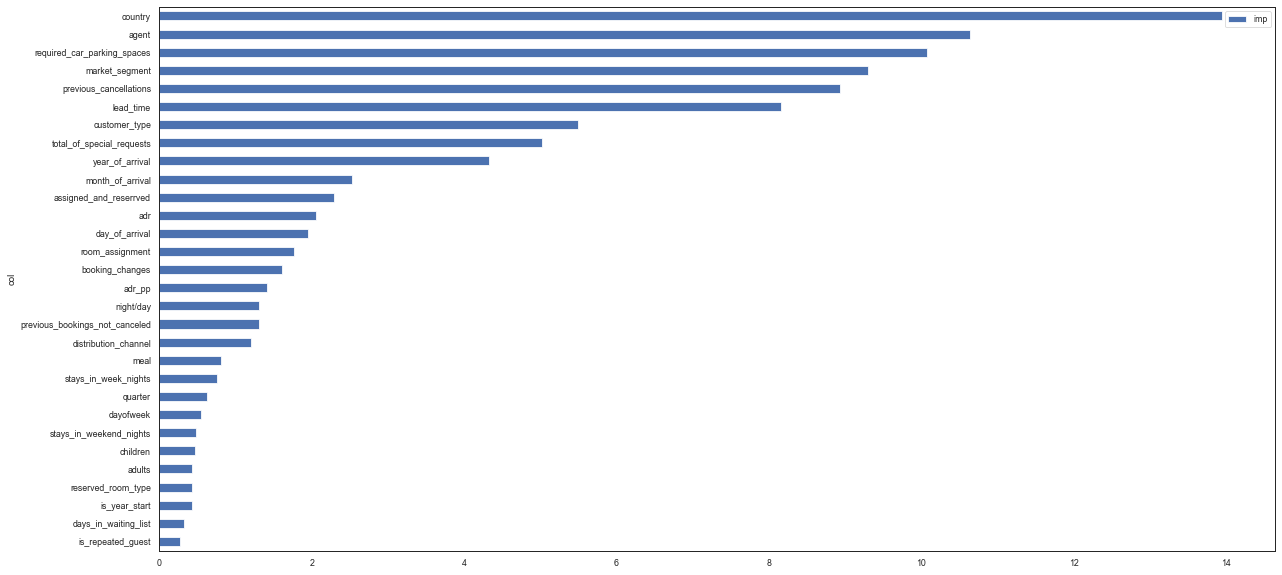

In [407]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')  

In [ ]:
d = {"id": test_id, 'is_canceled': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["id", 'is_canceled']]

In [409]:
test_predictions.head()

id  is_canceled
0  108786     0.151366
1  108787     0.247749
2  108788     0.000546
3  108789     0.821587
4  108790     0.410675

In [410]:
test_predictions.to_csv('catboost1.csv', index=False)

# CATBOOST MODEL 2

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submit.csv')

In [ ]:
test_id = test['id']

In [ ]:
train['arrival_date'] = pd.to_datetime(train['arrival_date'], format='%Y-%m-%d')
test['arrival_date'] = pd.to_datetime(test['arrival_date'], format='%Y-%m-%d')

In [ ]:
train['dayofweek'] = pd.DatetimeIndex(train['arrival_date']).dayofweek
train['is_weekend'] = train.dayofweek.isin([5,6])*1
train['quarter'] = train['arrival_date'].dt.quarter
train['month'] = train['arrival_date'].dt.month
train['year'] = train['arrival_date'].dt.year
train['day'] = train['arrival_date'].dt.day
train['is_year_start'] = train['arrival_date'].dt.is_year_start
train['is_year_end'] = train['arrival_date'].dt.is_year_end
train['is_month_start'] = train['arrival_date'].dt.is_month_start
train['is_month_end'] = train['arrival_date'].dt.is_month_end
train['is_quarter_start'] = train['arrival_date'].dt.is_quarter_start
test['dayofweek'] = pd.DatetimeIndex(test['arrival_date']).dayofweek
test['is_weekend'] = test.dayofweek.isin([5,6])*1
test['quarter'] = test['arrival_date'].dt.quarter
test['month'] = test['arrival_date'].dt.month
test['year'] = test['arrival_date'].dt.year
test['day'] = test['arrival_date'].dt.day
test['is_year_start'] = test['arrival_date'].dt.is_year_start
test['is_year_end'] = test['arrival_date'].dt.is_year_end
test['is_month_start'] = test['arrival_date'].dt.is_month_start
test['is_month_end'] = test['arrival_date'].dt.is_month_end
test['is_quarter_start'] = test['arrival_date'].dt.is_quarter_start
train= train.reset_index()
test= test.reset_index()

In [ ]:
train=train.drop(['id','arrival_date'], axis=1)
test=test.drop(['id','arrival_date'], axis=1)

In [ ]:
train["adr_pp"] = train["adr"] / (train["adults"] +train["children"])
test["adr_pp"] = test["adr"] / (test["adults"] +test["children"])
train["Beings"] = train["adults"]+ train["children"]+ train["babies"]
train['assigned-reserved'] = train['assigned_room_type'] + '_' + train['reserved_room_type']
test['assigned-reserved'] = test['assigned_room_type'] + '_' + test['reserved_room_type']
train["night/day"] = train["stays_in_weekend_nights"] + train["stays_in_week_nights"]
test["Beings"] = test["adults"]+ train["children"]+ test["babies"]
test["night/day"] = test["stays_in_weekend_nights"] + test["stays_in_week_nights"]

In [ ]:
X=train.drop(['is_canceled'], axis=1)
y=train.is_canceled

In [ ]:
cate_features_index=np.where(X.dtypes != float) [0]; cate_features_index

In [ ]:
# Split the data into 30% validation and 70% training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=5, shuffle=True, random_state=1993)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostClassifier(eval_metric='AUC')
    m.fit(X,y)
    #m.fit(X_train,y_train,cat_features=cate_features_index,eval_set=[(X_train,y_train),(X_val, y_val)],verbose=100, early_stopping_rounds=100)#,verbose=100)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

In [ ]:
np.mean(errcb)

In [ ]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    

In [ ]:
d = {"id": test_id, 'is_canceled': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["id", 'is_canceled']]

In [ ]:
test_predictions.head()

In [ ]:
test_predictions.to_csv('catboost2.csv', index=False)

# XGBOOST

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('submit.csv')

In [ ]:
test_id = test['id']

In [ ]:
train['arrival_date'] = pd.to_datetime(train['arrival_date'], format='%Y-%m-%d')
test['arrival_date'] = pd.to_datetime(test['arrival_date'], format='%Y-%m-%d')

In [ ]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)

In [ ]:
data['not_crawling_being'] = data.children+data.adults
data["Beings"] = data["adults"]+ data["children"]+ data["babies"]
data["adr_pp"] = data["adr"] / (data["adults"] +data["children"])
data['dayofweek'] = pd.DatetimeIndex(data['arrival_date']).dayofweek
data['is_weekend'] = data.dayofweek.isin([5,6])*1
data['quarter'] = data['arrival_date'].dt.quarter
data['month_of_arrival'] = data['arrival_date'].dt.month
data['year_of_arrival'] = data['arrival_date'].dt.year
data['day_of_arrival'] = data['arrival_date'].dt.day
data['is_year_start'] = data['arrival_date'].dt.is_year_start
data['is_year_end'] = data['arrival_date'].dt.is_year_end
data['is_month_start'] = data['arrival_date'].dt.is_month_start
data['is_month_end'] = data['arrival_date'].dt.is_month_end
data['is_quarter_start'] = data['arrival_date'].dt.is_quarter_start
data['assigned_and_reserrved'] = data['assigned_room_type'] + '_' + data['reserved_room_type']
data["night/day"] = data["stays_in_weekend_nights"] + data["stays_in_week_nights"]
data['billing']=data['night/day']*data.adr
data['room_assignment'] = data['reserved_room_type']==data['assigned_room_type']

In [ ]:
def encode_AG__2(group ,main_columns, aggregations, train_df=train, test_df=test, ext_src=None,
              fillna=True, usena=False):
    
    for main_column in main_columns:  
            for agg_type in aggregations:
                if ext_src is None: 
                    temp_df = pd.concat([train_df[group +[main_column]], test_df[group +[main_column]]])
                    new_col_name = group[0]+"_"+group[1]+"_"+main_column+'_'+agg_type
                                    
                else:
                    temp_df = ext_src.copy()
                    new_col_name = "ext_data"+ "_"+group[0]+"_"+group[1]+"_"+main_column+'_'+agg_type
                    
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby(group)[main_column].agg([agg_type]).reset_index(level=group).rename(
                                                        columns={agg_type: new_col_name})
                
                


                train_df[new_col_name] = pd.merge(train_df, temp_df, on=group, how='left')[new_col_name].astype('float32')
                test_df[new_col_name]  = pd.merge(test_df, temp_df, on=group, how='left')[new_col_name].astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
def encode_AG(uids ,main_columns, aggregations, train_df=train, test_df=test, ext_src=None,
              fillna=True, usena=False):
    
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                if ext_src is None: 
                    temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                    new_col_name = main_column+'_'+col+'_'+agg_type
                                    
                else:
                    temp_df = ext_src.copy()
                    new_col_name = "ext_data"+ "_"+main_column+'_'+col+'_'+agg_type

                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
def encode_CB(col1,col2,df1=train,df2=test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 

    print(nm,', ',end='')
    

def encode_AG2( uids,main_columns, train_df=train, test_df=test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

In [ ]:
reservation_data=data[data.is_canceled.notnull()].reset_index(drop=True)
test=data[data.is_canceled.isna()].reset_index(drop=True)

In [ ]:
encode_AG(['customer_type'] ,  ['lead_time'], ['mean','min','max','std'], train_df=reservation_data, test_df=test, 
              fillna=True, usena=False)

In [ ]:
lead = reservation_data[reservation_data['lead_time'] > 670].index
ms = reservation_data[reservation_data['market_segment'] == 'Undefined'].index
ar = reservation_data[reservation_data['assigned_room_type'] == 'L'].index 

In [ ]:
reservation_data.drop(lead, axis=0, inplace=True)
reservation_data.drop(ms, axis=0, inplace=True)
reservation_data.drop(ar, axis=0, inplace=True)

In [ ]:
reservation_data= reservation_data.reset_index()
test= test.reset_index()

In [ ]:
cols_drop=['id', 'arrival_date','not_crawling_being','billing','index','meal']
reservation_data=reservation_data.drop(cols_drop, axis=1);test=test.drop(cols_drop, axis=1)

In [ ]:
X=reservation_data.drop(['is_canceled'], axis=1);test=test.drop(['is_canceled'], axis=1)
y=reservation_data.is_canceled

In [ ]:
import category_encoders as ce
oce = ce.OneHotEncoder(cols=['hotel'])
hce = ce.TargetEncoder(cols=[ 'country', 'market_segment', 'distribution_channel',
'reserved_room_type', 'assigned_room_type', 'customer_type','assigned_and_reserrved'],smoothing=30,min_samples_leaf=7)

In [ ]:
X = oce.fit_transform(X)
X = hce.fit_transform(X,y)
test = oce.transform(test)
test = hce.transform(test)

In [ ]:
X["combiner"] = 1

In [ ]:
data = pd.concat([X, test])

In [ ]:
to_cluster=['Beings','company', 'country', 'customer_type','assigned_and_reserrved', 'is_repeated_guest',
            'total_of_special_requests','lead_time','hotel_2','adr']

In [ ]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(data[to_cluster])
pca = decomposition.PCA(n_components=3)
X_std_pca = pca.fit_transform(X_std)

In [ ]:
data["pc1"] = 0
data["pc2"] = 0
data["pc3"] = 0
data[["pc1","pc2","pc3"]] = X_std_pca

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=1996).fit(data[to_cluster])
data["kmeans"] = kmeans.predict(data[to_cluster])

In [ ]:
data=pd.concat([X,test])

In [ ]:
X=data[data.combiner.notnull()].reset_index(drop=True)
test=data[data.combiner.isna()].reset_index(drop=True)

In [ ]:
test=test.drop(['hotel_2','combiner'], axis=1)
X=X.drop(['hotel_2','combiner'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.ensemble import BaggingClassifier
    
errcb=[]
y_pred_totcb=[]
fold=RepeatedStratifiedKFold(n_splits=4, random_state=12345, n_repeats=4)
i=1

for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]#8, 0.5 2000
    m=XGBClassifier(depth=6, learning_rate=0.5, iterations=2000,random_state=42,num_boost_round=2000)
    m.fit(X,y)
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

In [ ]:
np.mean(errcb)

In [ ]:
d = {"id": test_id, 'is_canceled': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
test_predictions = test_predictions[["id", 'is_canceled']] 

In [ ]:
test_predictions.to_csv('xgboost2.csv', index=False)

# MODEL BLENDING

In [8]:
MODEL_A = 'catboost1.csv'
MODEL_B= 'lgbm.csv'
MODEL_C = 'catboost2.csv'
MODEL_D = 'xgboost2.csv'

In [9]:
MODEL__A = pd.read_csv(input_path + MODEL_A)
MODEL__B = pd.read_csv(input_path + MODEL_B)
MODEL__C = pd.read_csv(input_path + MODEL_C)
MODEL__D= pd.read_csv(input_path + MODEL_D)

In [10]:
MODEL__A['is_canceled'] =(MODEL__A['is_canceled'] * 0.52 + MODEL__B['is_canceled'] * 0.48) * 0.78 + MODEL__C['is_canceled']*0.22

In [11]:
file_name='blending_001.csv'
MODEL__A.to_csv(save_path + file_name, index=False)

In [12]:
MODEL__E = pd.read_csv('blending_001.csv')

In [13]:
MODEL__A['is_canceled'] =MODEL__E['is_canceled'] * 0.25 + MODEL__B['is_canceled'] * 0.15 + MODEL__C['is_canceled']*0.40 + MODEL__D['is_canceled']*0.20

In [14]:
file_name='Final_blendingx.csv'
MODEL__A.to_csv(save_path + file_name, index=False)